In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display, Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, BatchNormalization, Activation, concatenate
from tensorflow import feature_column

import datetime
import os
import gc

import joblib

import efficientnet.tfkeras as efn

## Load the tabular data

In [57]:
df_train = pd.read_csv('data/train.csv')

In [58]:
df_train.rename(columns={'age_approx':'age', 'anatom_site_general_challenge':'anatom'}, inplace = True)
df_train.dropna(axis=0, inplace = True)
df_train.isnull().sum()

image_name          0
patient_id          0
sex                 0
age                 0
anatom              0
diagnosis           0
benign_malignant    0
target              0
dtype: int64

In [59]:
df_train.head()

,image_name,patient_id,sex,age,anatom,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


## Prepration of tabular data by separating the target values

In [60]:
Tabular_data = df_train.drop(['benign_malignant', 'patient_id', 'diagnosis'], axis = 1)
targets = df_train.target
Tabular_data.head()

,image_name,sex,age,anatom,target
0,ISIC_2637011,male,45.0,head/neck,0
1,ISIC_0015719,female,45.0,upper extremity,0
2,ISIC_0052212,female,50.0,lower extremity,0
3,ISIC_0068279,female,45.0,head/neck,0
4,ISIC_0074268,female,55.0,upper extremity,0


In [61]:
filenames = ['data/jpeg/train/' + fname + '.jpg' for fname in Tabular_data.image_name]

In [62]:
Tabular_data = Tabular_data.drop(['image_name'], axis = 1)

## Converting the data into tensors suitable for TensorFlow

In [63]:
# Define image size
IMG_SIZE = 256
def process_image(img_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [64]:
def create_df(image, tabular, target):
    image = process_image(image)

    return {'img_inp': image, 'tab_inp':  tabular}, target

In [65]:
# Targets are in numeric format but our images are still just file paths.
X = filenames

## Preparing the tabular data for TensorFlow

In [66]:
feature_columns = []
feature_input = {}


age = feature_column.numeric_column('age')
feature_columns.append(age)
feature_input['age'] = tf.keras.Input(shape = (1,), name = 'age')

age_buckets = feature_column.bucketized_column(age, boundaries=[30, 45, 85])
feature_columns.append(age_buckets)

sex = feature_column.categorical_column_with_vocabulary_list('sex', ['male', 'female'])
sex = feature_column.indicator_column(sex)
feature_columns.append(sex)
feature_input['sex'] = tf.keras.Input(shape = (1,), name = 'sex', dtype = tf.string)

anatom = feature_column.categorical_column_with_hash_bucket('anatom', hash_bucket_size=6)
anatom = feature_column.indicator_column(anatom)
feature_columns.append(anatom)
feature_input['anatom'] = tf.keras.Input(shape = (1,), name = 'anatom', dtype=tf.string)


feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [67]:
feature_input

{'age': <tf.Tensor 'age_2:0' shape=(None, 1) dtype=float32>,
 'sex': <tf.Tensor 'sex_2:0' shape=(None, 1) dtype=string>,
 'anatom': <tf.Tensor 'anatom_2:0' shape=(None, 1) dtype=string>}

In [68]:
# The dataset is heavily unbalanced. Therefore it is essential to calculate the weight of each class

Total_num_img = len(df_train)
Num_mlg = np.count_nonzero(df_train.target)
Num_bng = Total_num_img - Num_mlg

Weight_bng = 1/Num_bng * Total_num_img/2
Weight_mlg = 1/Num_mlg * Total_num_img/2

class_weights = {0: Weight_bng, 1: Weight_mlg}

## Creating and training a model

In [69]:
# Size of the input, hidden layer and output of the neural network
INPUT_SIZE = [IMG_SIZE,IMG_SIZE, 3]
OUTPUT_SIZE = 2

In [70]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path)
  return model

In [71]:
def create_model(retrain = False):
    model = []
    if retrain:
        files = os.listdir('models')
        paths = [os.path.join('models/', basename) for basename in files]
        model_path = max(paths, key=os.path.getctime)
        model = load_model(model_path)
    else:        
        img_inp = Input(shape = INPUT_SIZE, name = 'img_inp') # Image input for EfficientNet

        efnB3 = efn.EfficientNetB3(weights = 'imagenet', include_top = False)
        x1 = efnB3(img_inp)
        x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)


        # Tabular data 
        x2 = feature_layer(feature_input)
        x2 = Dense(50)(x2)
        x2 = BatchNormalization()(x2)
        x2 = Activation('relu')(x2)   
        
        # Combining the result of the two branches from images and tabular data
        concat = concatenate([x1, x2])
        concat = Dense(256, activation = 'relu')(concat)
        concat = BatchNormalization()(concat)
        concat = Dropout(0.2)(concat)

        
        concat = Dense(128, activation = 'relu')(concat)
        concat = BatchNormalization()(concat)
        concat = Dropout(0.2)(concat)

        
        concat = Dense(64, activation = 'relu')(concat)
        concat = BatchNormalization()(concat)
        concat = Dropout(0.2)(concat)


        outputs = Dense(OUTPUT_SIZE, activation= 'softmax')(concat)

        model = tf.keras.models.Model(inputs = [img_inp, feature_input], outputs = outputs)

        model.compile(
                    optimizer = tf.keras.optimizers.SGD(lr = 1e-3),
                    loss = tf.keras.losses.BinaryCrossentropy(),
                    metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])

    return model

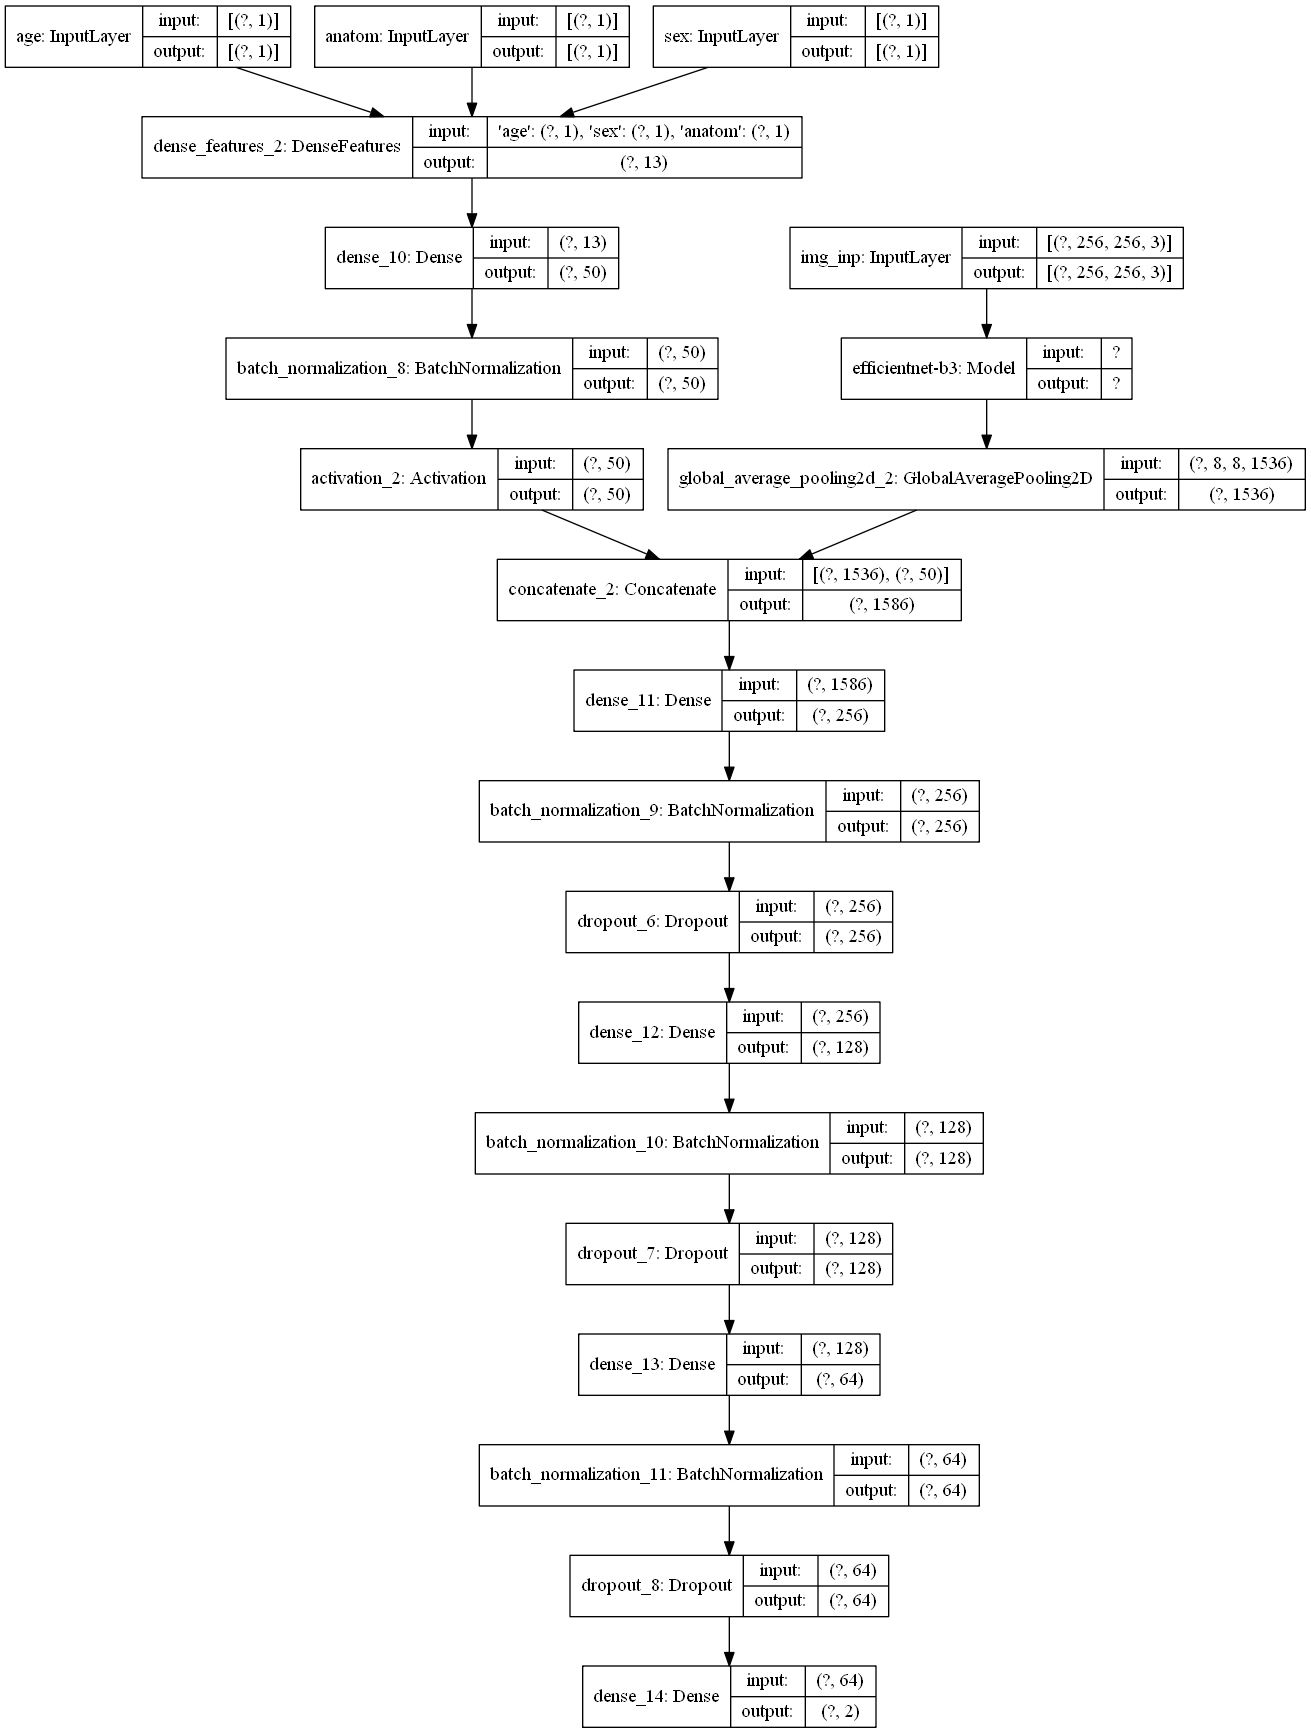

In [72]:
# Visualizing the network
model = create_model()
tf.keras.utils.plot_model(model, show_shapes=True)

In [73]:
# Creating callbacks
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4)
Rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=0, mode='auto', cooldown=0, min_lr=1e-6)

In [74]:
BATCH_SIZE = 45

def get_data(X, Tabular_data):

    x_train, x_val, tabular_train, tabular_val = train_test_split(X[:], Tabular_data[:], test_size = 0.2, random_state = 42)

    y_train = pd.get_dummies(tabular_train.target)
    tabular_train.drop('target', axis = 1, inplace = True)

    y_val = pd.get_dummies(tabular_val.target)
    tabular_val.drop('target', axis = 1, inplace = True)


    
    
    train_data = tf.data.Dataset.from_tensor_slices((tf.constant(x_train),dict(tabular_train),tf.constant(y_train)))
    train_data = train_data.map(create_df).shuffle(buffer_size = len(x_train))
    train_data = train_data.batch(BATCH_SIZE)
    
    
    val_data = tf.data.Dataset.from_tensor_slices((tf.constant(x_val),dict(tabular_val),tf.constant(y_val)))
    val_data = val_data.map(create_df).batch(BATCH_SIZE)

    return train_data, val_data

In [75]:
# Function for saving the model after each fold
def save_model_loop(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  
  model_path = "models/model" + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

## Dividing data into folds and train in separate rounds

In [76]:
folds = 5
kfolds = KFold(folds, shuffle = True, random_state = 42)

In [77]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}
gc.collect()

2172

In [ ]:
targets_temp = Tabular_data.target
models = []
History = []
# Set number of images to use for experimenting
First_Image = 0
Last_Image = 30

# Loop over the folds, train the model on each fold and save the results
for fold, (_, target_idx) in enumerate(kfolds.split(targets_temp)):
    X_fold = [X[i] for i in list(target_idx)]
    Tabular_fold = Tabular_data.iloc[target_idx]
    [train_data, val_data] = get_data(X_fold, Tabular_fold)
    if fold == 0:
        model = create_model()
    else:
        model = create_model(True)
        model.compile(
                    optimizer = tf.keras.optimizers.SGD(lr = 1e-3/fold),
                    loss = tf.keras.losses.BinaryCrossentropy(),
                    metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])

    history = model.fit(train_data, epochs=NUM_EPOCHS, validation_data=val_data, validation_freq=1, callbacks=[EarlyStopping, Rate], class_weight = class_weights)
    History.append(history)
    sfx = "EfficientNet3B_Img_Tab_fold{}".format(fold)
    save_model_loop(model, suffix=sfx)

    

In [ ]:
plt.plot(history.history['val_loss'], color = 'red')
plt.plot(history.history['loss'], color = 'blue')
plt.legend(['Validation', 'Training'])
plt.title('Loss')
plt.show()

## Save the results

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("models",
                          datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
sfx = "EfficientNet3B_Img_Tab"
save_model(model, suffix=sfx)